<a href="https://colab.research.google.com/github/tcristea/ILF/blob/main/KB-Strat2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kalman-Bucy and Stratonovich filter, custome code, side by side

---



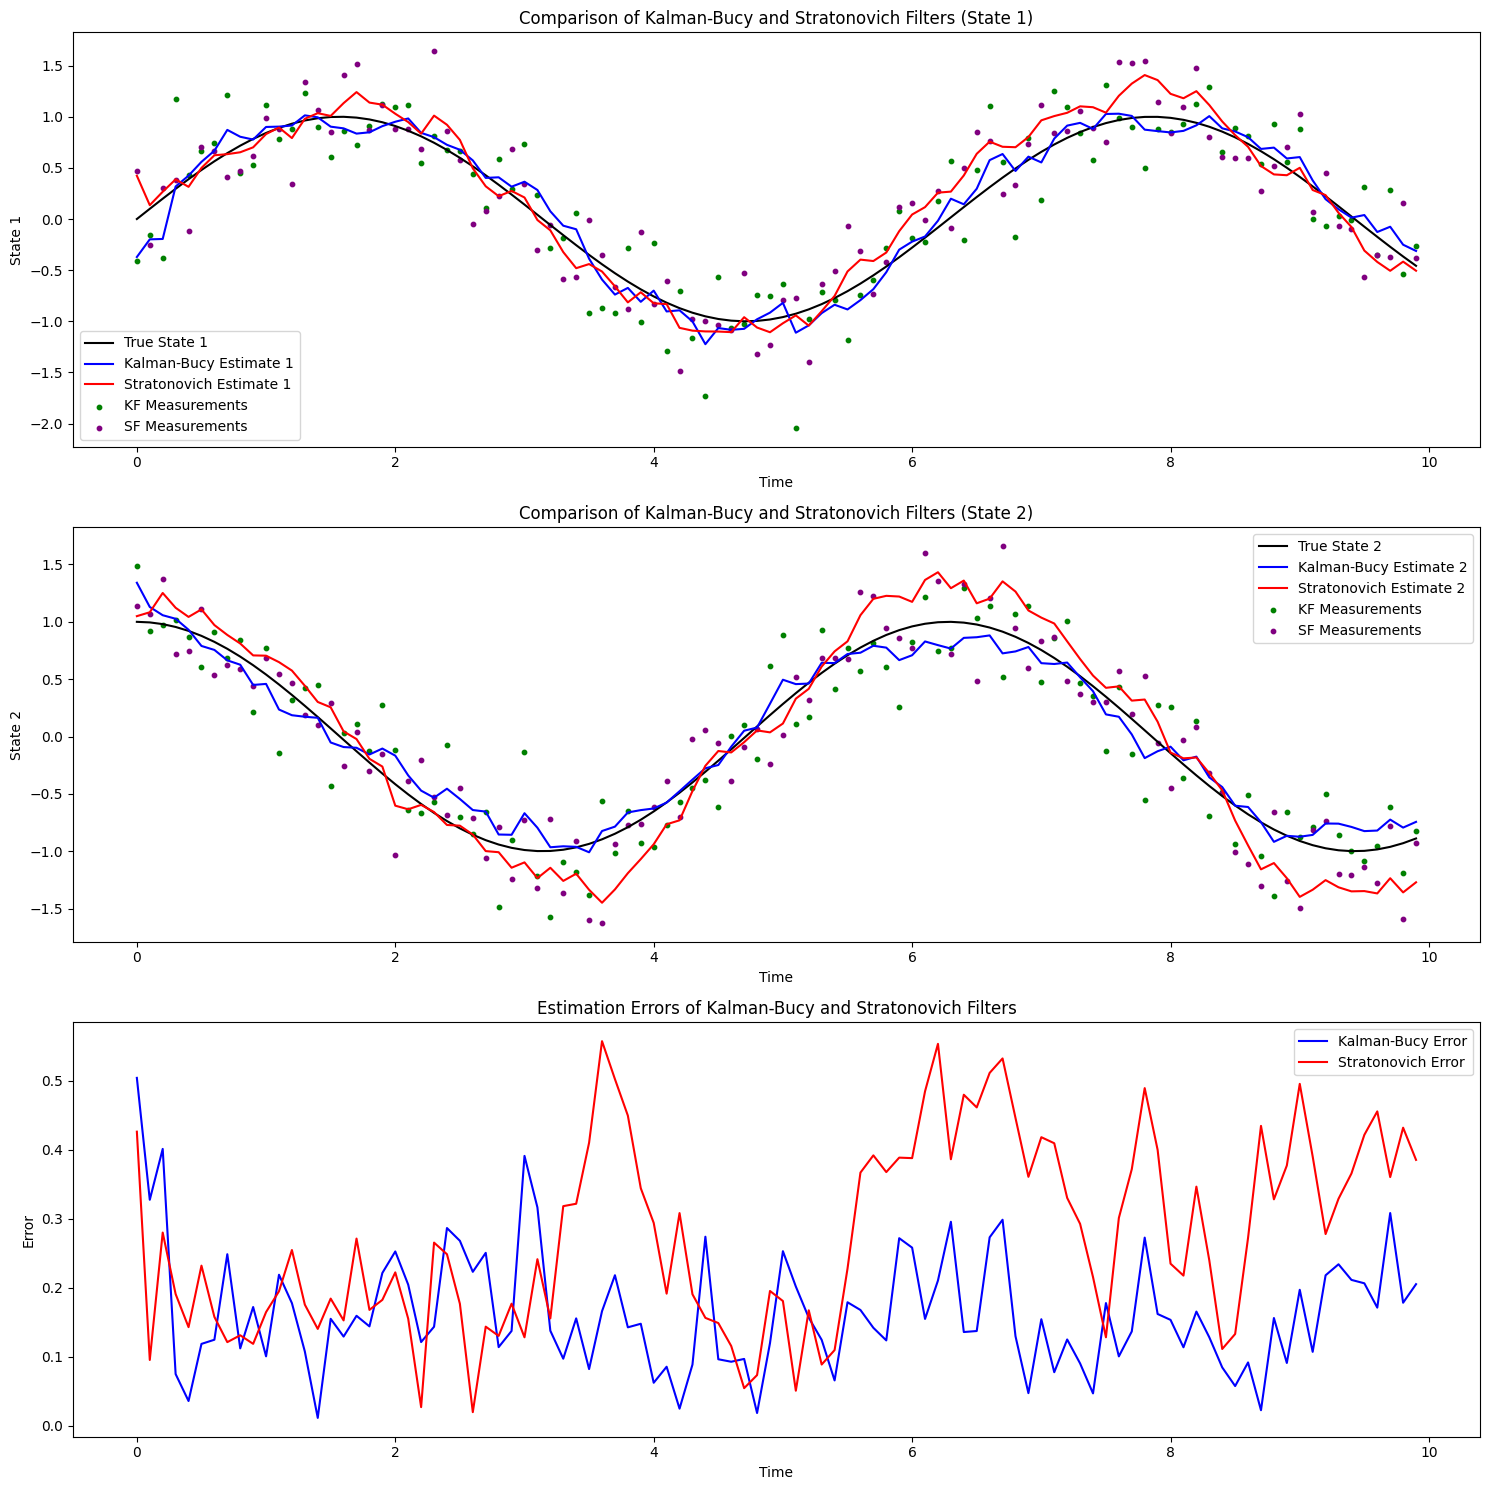

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Kalman-Bucy Filter Implementation
class KalmanBucyFilter:
    def __init__(self, A, B, H, Q, R):
        self.A = A
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.P = np.eye(A.shape[0])
        self.x = np.zeros((A.shape[0], 1))

    def predict(self, u, dt):
        self.x = self.x + (self.A @ self.x + self.B @ u) * dt
        self.P = self.P + (self.A @ self.P + self.P @ self.A.T + self.Q) * dt

    def update(self, z):
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)
        self.x = self.x + K @ (z - self.H @ self.x)
        self.P = self.P - K @ self.H @ self.P

    def step(self, u, z, dt):
        self.predict(u, dt)
        self.update(z)
        return self.x

# Stratonovich Filter Implementation
class StratonovichFilter:
    def __init__(self, f, h, Q, R):
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R
        self.P = np.eye(Q.shape[0])
        self.x = np.zeros((Q.shape[0], 1))

    def predict(self, u, dt):
        self.x = self.x + self.f(self.x, u) * dt
        F = self._jacobian_f(self.x, u)
        self.P = self.P + (F @ self.P + self.P @ F.T + self.Q) * dt

    def update(self, z):
        H = self._jacobian_h(self.x)
        K = self.P @ H.T @ np.linalg.inv(H @ self.P @ H.T + self.R)
        self.x = self.x + K @ (z - self.h(self.x))
        self.P = self.P - K @ H @ self.P

    def step(self, u, z, dt):
        self.predict(u, dt)
        self.update(z)
        return self.x

    def _jacobian_f(self, x, u):
        # Numerical Jacobian of f
        epsilon = 1e-5
        n = x.shape[0]
        F = np.zeros((n, n))
        for i in range(n):
            x1 = x.copy()
            x2 = x.copy()
            x1[i, 0] += epsilon
            x2[i, 0] -= epsilon
            F[:, i] = (self.f(x1, u) - self.f(x2, u)).flatten() / (2 * epsilon)
        return F

    def _jacobian_h(self, x):
        # Numerical Jacobian of h
        epsilon = 1e-5
        n = x.shape[0]
        m = self.h(x).shape[0]
        H = np.zeros((m, n))
        for i in range(n):
            x1 = x.copy()
            x2 = x.copy()
            x1[i, 0] += epsilon
            x2[i, 0] -= epsilon
            H[:, i] = (self.h(x1) - self.h(x2)).flatten() / (2 * epsilon)
        return H

# Define the system parameters
A = np.array([[0, 1], [-1, -0.5]])
B = np.array([[0], [1]])
H_kf = np.eye(2)  # Measurement function for both state components
Q = np.array([[0.1, 0], [0, 0.1]])
R = np.eye(2) * 0.1  # Measurement noise for both state components

def f(x, u):
    return np.array([[x[1, 0]], [-x[0, 0] + np.sin(x[1, 0]) + u[0, 0]]])

def h(x):
    return np.array([[x[0, 0]], [x[1, 0]]])  # Measurements for both state components

# Initialize filters
kf = KalmanBucyFilter(A, B, H_kf, Q, R)
sf = StratonovichFilter(f, h, Q, R)

# Simulate a scenario
u = np.array([[0.1]])  # Non-zero control input to affect the state
dt = 0.1
states_kf = []
states_sf = []
true_states = []
measurements_kf = []
measurements_sf = []
time = np.arange(0, 10, dt)

for t in time:
    true_state = np.array([[np.sin(t)], [np.cos(t)]])
    z_kf = H_kf @ true_state + np.random.normal(0, np.sqrt(R[0, 0]), (2, 1))
    z_sf = h(true_state) + np.random.normal(0, np.sqrt(R[0, 0]), (2, 1))

    kf_state = kf.step(u, z_kf, dt)
    sf_state = sf.step(u, z_sf, dt)

    states_kf.append(kf_state)
    states_sf.append(sf_state)
    true_states.append(true_state)
    measurements_kf.append(z_kf)
    measurements_sf.append(z_sf)

# Convert lists to numpy arrays for easier plotting
states_kf = np.hstack(states_kf)
states_sf = np.hstack(states_sf)
true_states = np.hstack(true_states)
measurements_kf = np.hstack(measurements_kf)
measurements_sf = np.hstack(measurements_sf)

# Calculate errors
errors_kf = np.linalg.norm(states_kf - true_states, axis=0)
errors_sf = np.linalg.norm(states_sf - true_states, axis=0)

# Plot the results
plt.figure(figsize=(15, 15))

# State 1
plt.subplot(3, 1, 1)
plt.plot(time, true_states[0, :], label='True State 1', color='black')
plt.plot(time, states_kf[0, :], label='Kalman-Bucy Estimate 1', color='blue')
plt.plot(time, states_sf[0, :], label='Stratonovich Estimate 1', color='red')
plt.scatter(time, measurements_kf[0, :], label='KF Measurements', color='green', s=10)
plt.scatter(time, measurements_sf[0, :], label='SF Measurements', color='purple', s=10)
plt.xlabel('Time')
plt.ylabel('State 1')
plt.legend()
plt.title('Comparison of Kalman-Bucy and Stratonovich Filters (State 1)')

# State 2
plt.subplot(3, 1, 2)
plt.plot(time, true_states[1, :], label='True State 2', color='black')
plt.plot(time, states_kf[1, :], label='Kalman-Bucy Estimate 2', color='blue')
plt.plot(time, states_sf[1, :], label='Stratonovich Estimate 2', color='red')
plt.scatter(time, measurements_kf[1, :], label='KF Measurements', color='green', s=10)
plt.scatter(time, measurements_sf[1, :], label='SF Measurements', color='purple', s=10)
plt.xlabel('Time')
plt.ylabel('State 2')
plt.legend()
plt.title('Comparison of Kalman-Bucy and Stratonovich Filters (State 2)')

# Errors
plt.subplot(3, 1, 3)
plt.plot(time, errors_kf, label='Kalman-Bucy Error', color='blue')
plt.plot(time, errors_sf, label='Stratonovich Error', color='red')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.title('Estimation Errors of Kalman-Bucy and Stratonovich Filters')

plt.tight_layout()
plt.show()


Kalman-Bucy and Stratonovich filter, library code, side by side, one of two states with measurements.

In [ ]:
!pip install filterpy
!pip install sdeint

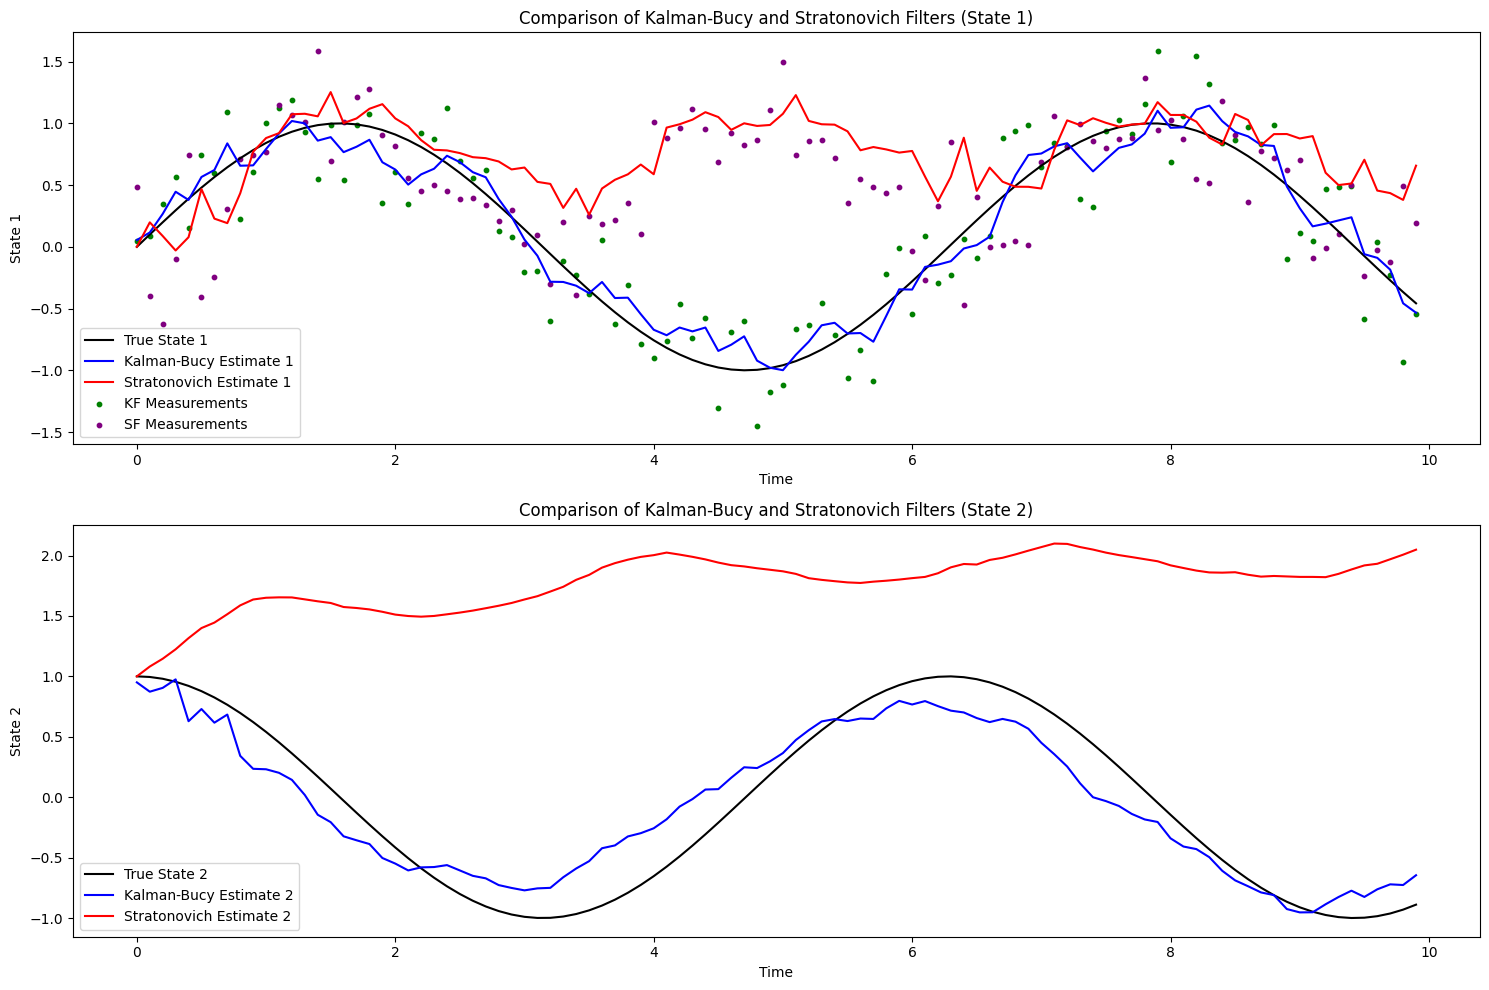

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import sdeint

# Kalman-Bucy Filter using FilterPy (discrete approximation)
def kalman_bucy_filter(A, B, H, Q, R, x0, u, measurements, dt):
    kf = KalmanFilter(dim_x=A.shape[0], dim_z=H.shape[0])
    kf.F = np.eye(A.shape[0]) + A * dt  # Discretized system matrix
    kf.B = B * dt  # Discretized control matrix
    kf.H = H
    kf.Q = Q * dt  # Discretized process noise
    kf.R = R
    kf.x = x0
    kf.P = np.eye(A.shape[0])

    states = []

    for z in measurements:
        kf.predict(u=u)
        kf.update(z)
        states.append(kf.x.copy())

    return np.array(states)

# Stratonovich Filter using sdeint
def f(x, t):
    return np.array([x[1], -x[0] + np.sin(x[1])])

def G(x, t):
    return np.array([[0, 0], [0, 0]])

def h(x):
    return np.array([x[0] ** 2])

def stratonovich_filter(f, G, h, Q, R, x0, measurements, dt):
    n_steps = len(measurements)
    states = [x0]
    x = x0

    for k in range(n_steps - 1):
        t = k * dt
        z = measurements[k]
        x = sdeint.itoint(f, G, x, [t, t+dt])[-1]
        H = np.array([[2 * x[0], 0]])
        K = Q @ H.T @ np.linalg.inv(H @ Q @ H.T + R)
        x = x + K @ (z - h(x))
        states.append(x.copy())

    return np.array(states)

# Define the system parameters
A = np.array([[0, 1], [-1, -0.5]])
B = np.array([[0], [1]])
H = np.array([[1, 0]])
Q = np.array([[0.1, 0], [0, 0.1]])
R = np.array([[0.1]])
x0 = np.array([0, 1])
u = np.array([0])

# Simulate the true state and measurements
dt = 0.1
time = np.arange(0, 10, dt)
true_states = np.array([[np.sin(t), np.cos(t)] for t in time])
measurements_kf = np.array([H @ state + np.random.normal(0, np.sqrt(R[0, 0]), 1) for state in true_states])
measurements_sf = np.array([state[0] ** 2 + np.random.normal(0, np.sqrt(R[0, 0]), 1) for state in true_states])

# Run the filters
kf_states = kalman_bucy_filter(A, B, H, Q, R, x0, u, measurements_kf, dt)
sf_states = stratonovich_filter(f, G, h, Q, R, x0, measurements_sf, dt)

# Plot the results
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(time, true_states[:, 0], label='True State 1', color='black')
plt.plot(time, kf_states[:, 0], label='Kalman-Bucy Estimate 1', color='blue')
plt.plot(time, sf_states[:, 0], label='Stratonovich Estimate 1', color='red')
plt.scatter(time, measurements_kf[:, 0], label='KF Measurements', color='green', s=10)
plt.scatter(time, measurements_sf[:, 0], label='SF Measurements', color='purple', s=10)
plt.xlabel('Time')
plt.ylabel('State 1')
plt.legend()
plt.title('Comparison of Kalman-Bucy and Stratonovich Filters (State 1)')

plt.subplot(2, 1, 2)
plt.plot(time, true_states[:, 1], label='True State 2', color='black')
plt.plot(time, kf_states[:, 1], label='Kalman-Bucy Estimate 2', color='blue')
plt.plot(time, sf_states[:, 1], label='Stratonovich Estimate 2', color='red')
plt.xlabel('Time')
plt.ylabel('State 2')
plt.legend()
plt.title('Comparison of Kalman-Bucy and Stratonovich Filters (State 2)')

plt.tight_layout()
plt.show()


Kalman-Bucy filter, library code, two states measurements

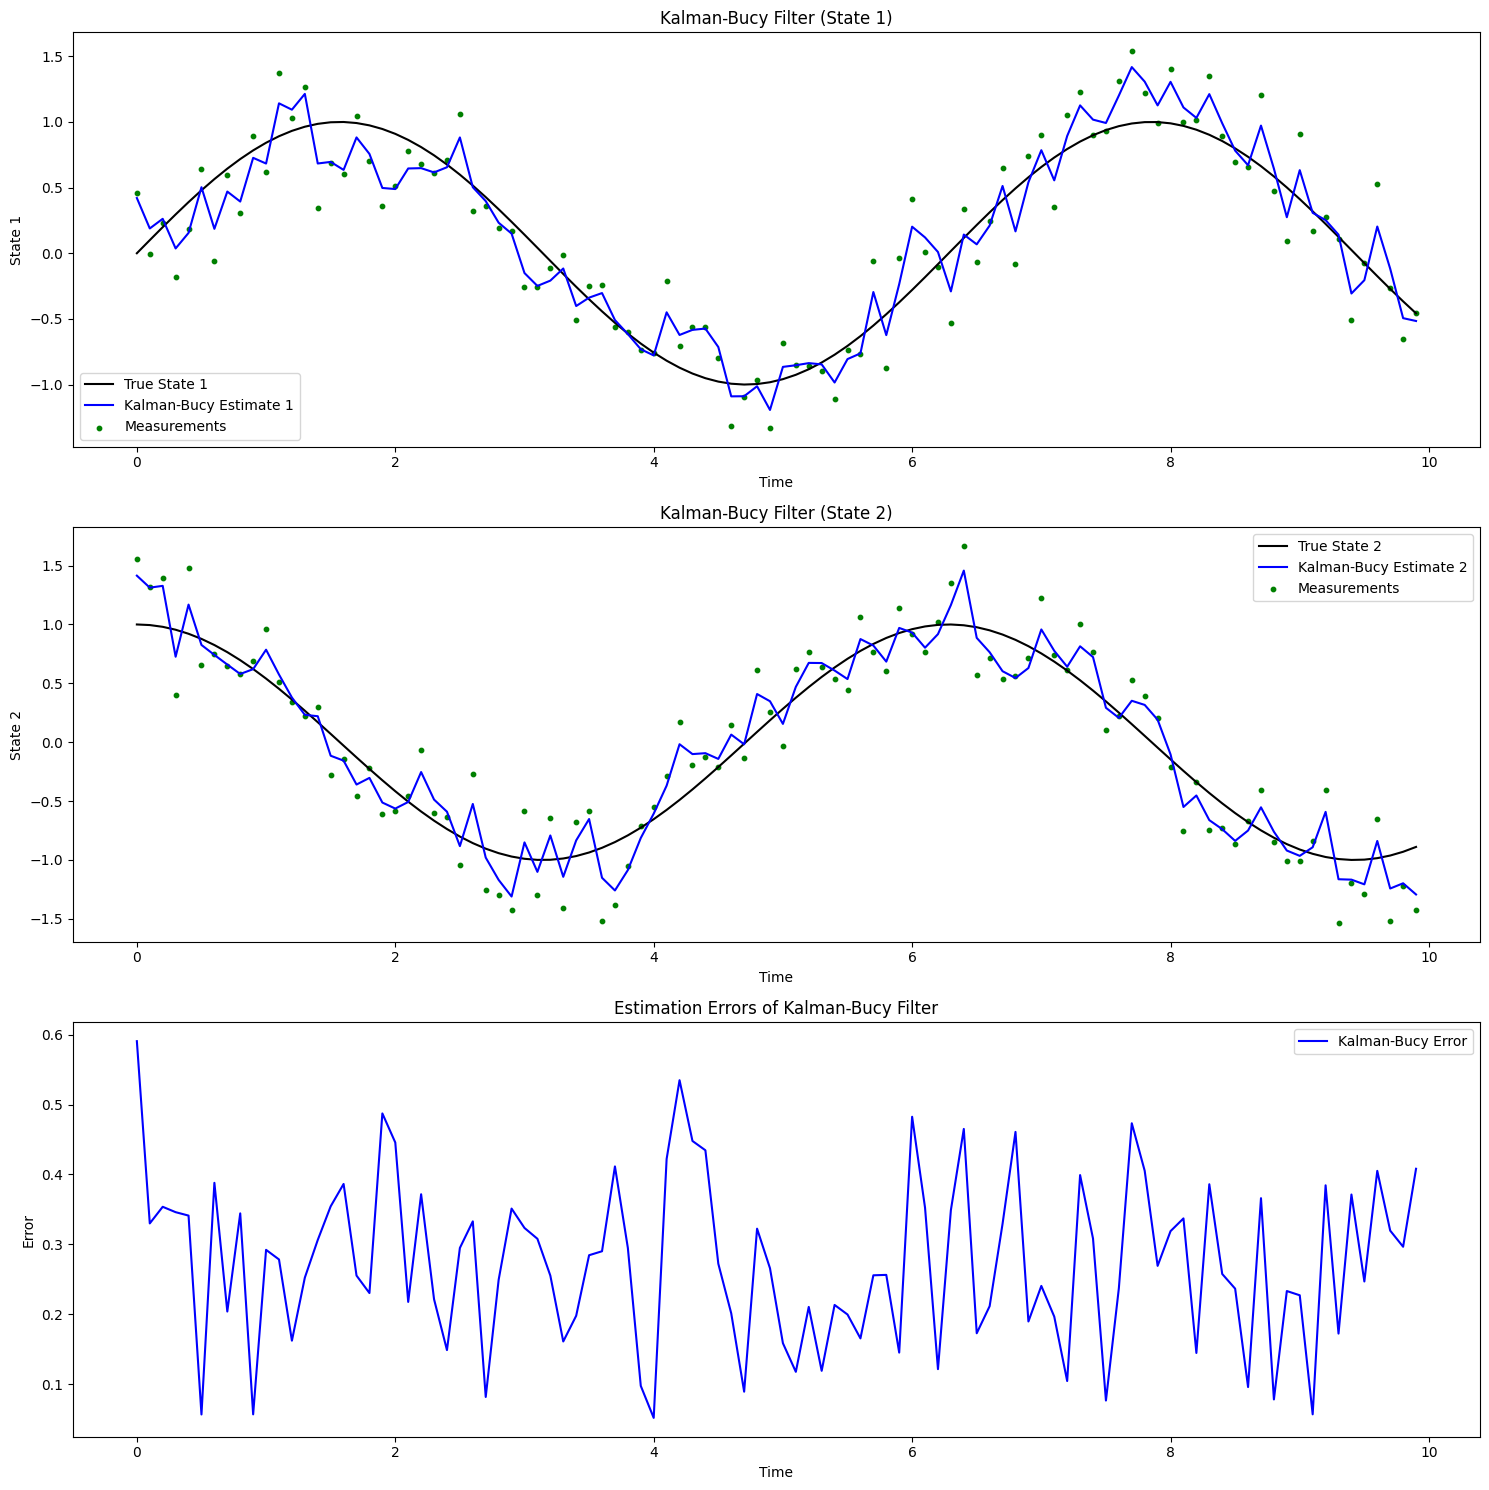

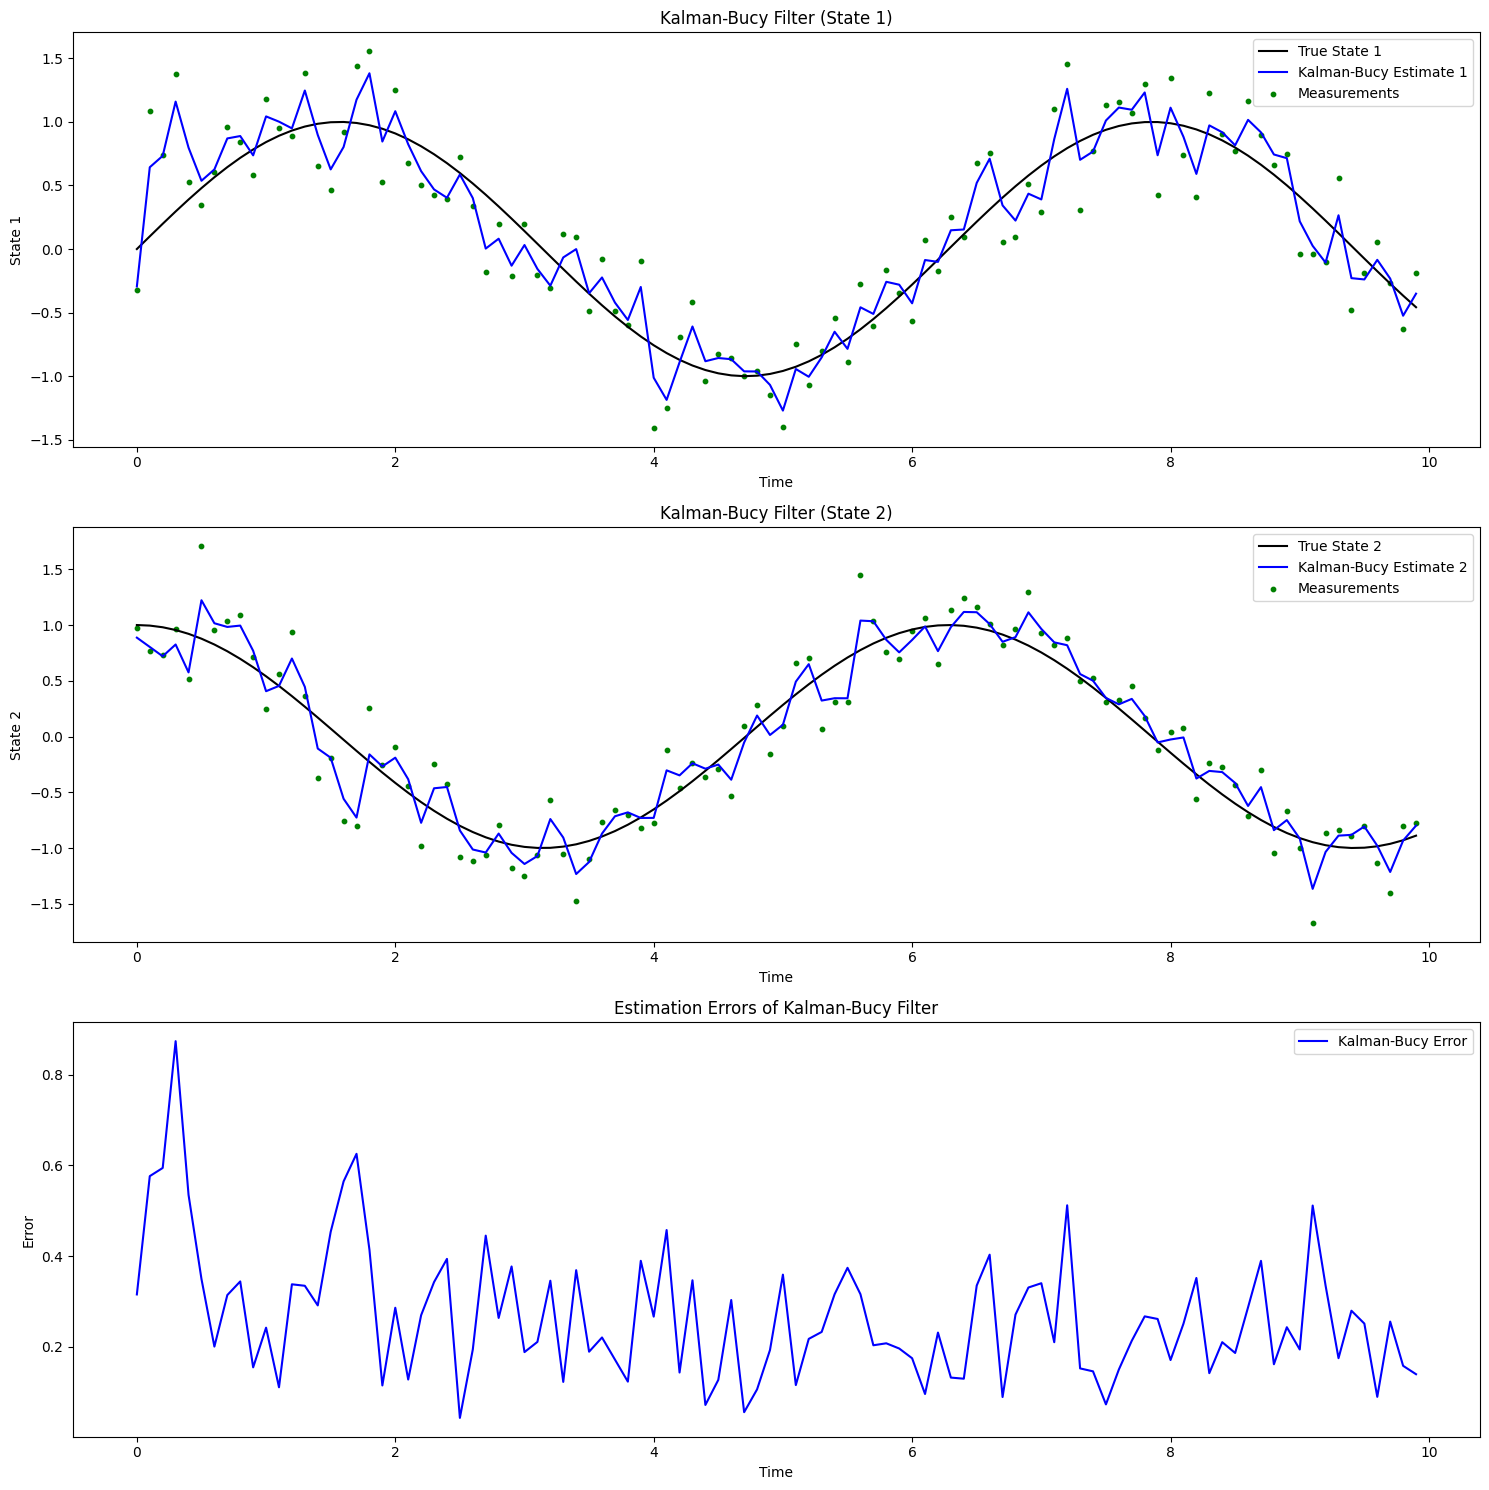

In [124]:
from filterpy.kalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# Define the system parameters
dt = 0.1
A = np.array([[1.0, dt], [-dt, 1.0 - 0.5 * dt]])
B = np.array([[0.0], [dt]])
H = np.eye(2)
Q = np.array([[0.1, 0.0], [0.0, 0.1]])
R = np.eye(2) * 0.1

# Initialize Kalman filter
kf = KalmanFilter(dim_x=2, dim_z=2)
kf.F = A
kf.H = H
kf.Q = Q
kf.R = R
kf.x = np.zeros((2, 1))
kf.P = np.eye(2)

# Simulate a scenario
u = np.array([[0.1]])  # Non-zero control input to affect the state
states_kf = []
true_states = []
measurements_kf = []
time = np.arange(0, 10, dt)

for t in time:
    true_state = np.array([[np.sin(t)], [np.cos(t)]])
    z = H @ true_state + np.random.normal(0.0, np.sqrt(R[0, 0]), (2, 1))

    kf.predict(u=u)
    kf.update(z)

    states_kf.append(kf.x.copy())
    true_states.append(true_state)
    measurements_kf.append(z)

# Convert lists to numpy arrays for easier plotting
states_kf = np.hstack(states_kf)
true_states = np.hstack(true_states)
measurements_kf = np.hstack(measurements_kf)

# Calculate errors
errors_kf = np.linalg.norm(states_kf - true_states, axis=0)

# Plot the results
plt.figure(figsize=(15, 15))

# State 1
plt.subplot(3, 1, 1)
plt.plot(time, true_states[0, :], label='True State 1', color='black')
plt.plot(time, states_kf[0, :], label='Kalman-Bucy Estimate 1', color='blue')
plt.scatter(time, measurements_kf[0, :], label='Measurements', color='green', s=10)
plt.xlabel('Time')
plt.ylabel('State 1')
plt.legend()
plt.title('Kalman-Bucy Filter (State 1)')

# State 2
plt.subplot(3, 1, 2)
plt.plot(time, true_states[1, :], label='True State 2', color='black')
plt.plot(time, states_kf[1, :], label='Kalman-Bucy Estimate 2', color='blue')
plt.scatter(time, measurements_kf[1, :], label='Measurements', color='green', s=10)
plt.xlabel('Time')
plt.ylabel('State 2')
plt.legend()
plt.title('Kalman-Bucy Filter (State 2)')

# Errors
plt.subplot(3, 1, 3)
plt.plot(time, errors_kf, label='Kalman-Bucy Error', color='blue')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.title('Estimation Errors of Kalman-Bucy Filter')

plt.tight_layout()
plt.show()
from filterpy.kalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# Define the system parameters
dt = 0.1
A = np.array([[1.0, dt], [-dt, 1.0 - 0.5 * dt]])
B = np.array([[0.0], [dt]])
H = np.eye(2)
Q = np.array([[0.1, 0.0], [0.0, 0.1]])
R = np.eye(2) * 0.1

# Initialize Kalman filter
kf = KalmanFilter(dim_x=2, dim_z=2)
kf.F = A
kf.H = H
kf.Q = Q
kf.R = R
kf.x = np.zeros((2, 1))
kf.P = np.eye(2)

# Simulate a scenario
u = np.array([[0.1]])  # Non-zero control input to affect the state
states_kf = []
true_states = []
measurements_kf = []
time = np.arange(0, 10, dt)

for t in time:
    true_state = np.array([[np.sin(t)], [np.cos(t)]])
    z = H @ true_state + np.random.normal(0.0, np.sqrt(R[0, 0]), (2, 1))

    kf.predict(u=u)
    kf.update(z)

    states_kf.append(kf.x.copy())
    true_states.append(true_state)
    measurements_kf.append(z)

# Convert lists to numpy arrays for easier plotting
states_kf = np.hstack(states_kf)
true_states = np.hstack(true_states)
measurements_kf = np.hstack(measurements_kf)

# Calculate errors
errors_kf = np.linalg.norm(states_kf - true_states, axis=0)

# Plot the results
plt.figure(figsize=(15, 15))

# State 1
plt.subplot(3, 1, 1)
plt.plot(time, true_states[0, :], label='True State 1', color='black')
plt.plot(time, states_kf[0, :], label='Kalman-Bucy Estimate 1', color='blue')
plt.scatter(time, measurements_kf[0, :], label='Measurements', color='green', s=10)
plt.xlabel('Time')
plt.ylabel('State 1')
plt.legend()
plt.title('Kalman-Bucy Filter (State 1)')

# State 2
plt.subplot(3, 1, 2)
plt.plot(time, true_states[1, :], label='True State 2', color='black')
plt.plot(time, states_kf[1, :], label='Kalman-Bucy Estimate 2', color='blue')
plt.scatter(time, measurements_kf[1, :], label='Measurements', color='green', s=10)
plt.xlabel('Time')
plt.ylabel('State 2')
plt.legend()
plt.title('Kalman-Bucy Filter (State 2)')

# Errors
plt.subplot(3, 1, 3)
plt.plot(time, errors_kf, label='Kalman-Bucy Error', color='blue')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.title('Estimation Errors of Kalman-Bucy Filter')

plt.tight_layout()
plt.show()


Stratonovich filter, library code, two states measurements

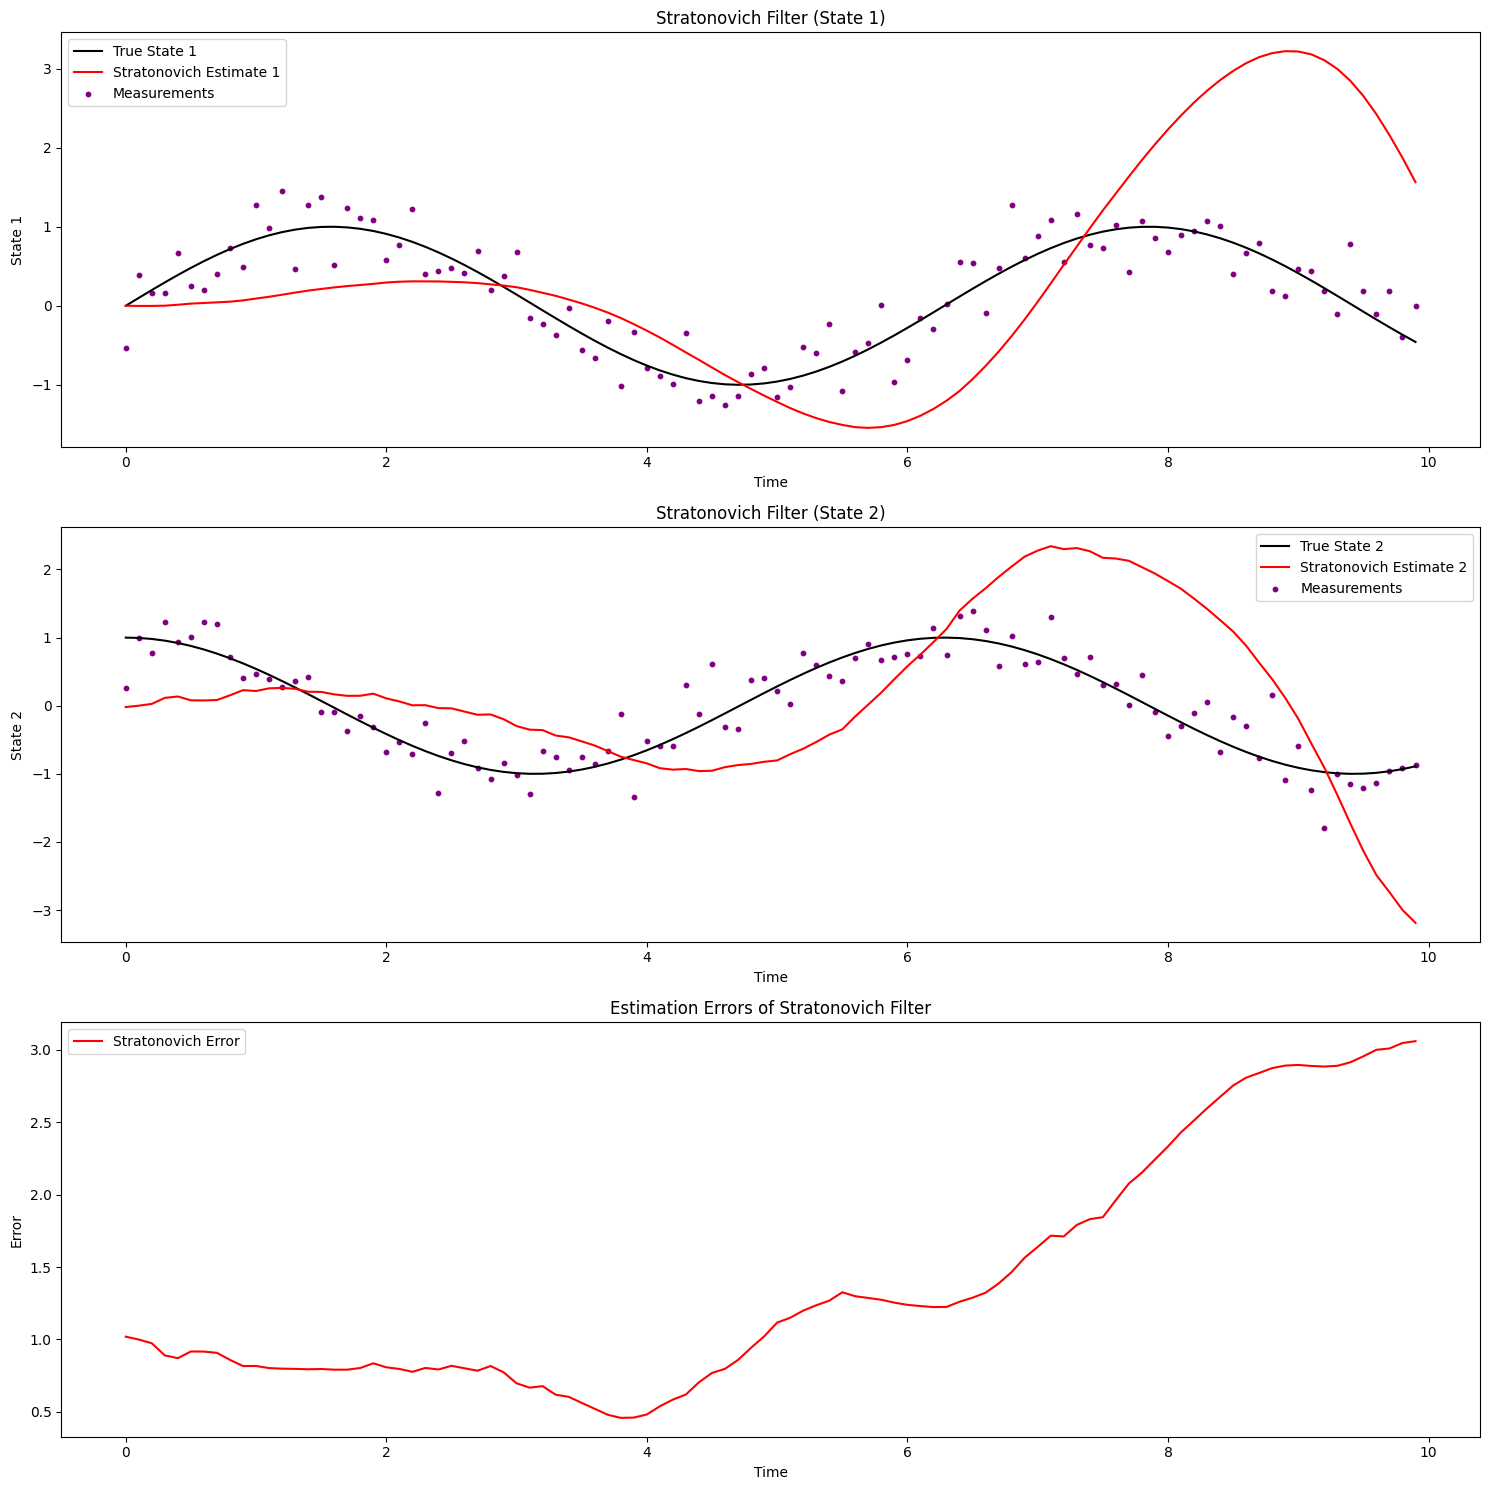

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import sdeint

# Define the system parameters
Q = np.array([[0.1, 0.0], [0.0, 0.1]])
R = np.eye(2) * 0.1

def f(x, t):
    return np.array([x[1], -x[0] + np.sin(x[1])])

def G(x, t):
    return np.array([[0.0, 0.0], [0.0, 0.1]])

def h(x):
    return np.array([x[0], x[1]])

# Simulate a scenario
u = np.array([0.1])  # Non-zero control input to affect the state
dt = 0.1
states_sf = []
true_states = []
measurements_sf = []
time = np.arange(0, 10, dt)

x0 = np.zeros(2)  # Initial state

for t in time:
    true_state = np.array([np.sin(t), np.cos(t)])
    z = h(true_state) + np.random.normal(0.0, np.sqrt(R[0, 0]), 2)

    x0 = sdeint.itoint(f, G, x0, [t, t+dt])[-1]

    states_sf.append(x0.copy())
    true_states.append(true_state)
    measurements_sf.append(z)

# Convert lists to numpy arrays for easier plotting
states_sf = np.array(states_sf).T
true_states = np.array(true_states).T
measurements_sf = np.array(measurements_sf).T

# Calculate errors
errors_sf = np.linalg.norm(states_sf - true_states, axis=0)

# Plot the results
plt.figure(figsize=(15, 15))

# State 1
plt.subplot(3, 1, 1)
plt.plot(time, true_states[0, :], label='True State 1', color='black')
plt.plot(time, states_sf[0, :], label='Stratonovich Estimate 1', color='red')
plt.scatter(time, measurements_sf[0, :], label='Measurements', color='purple', s=10)
plt.xlabel('Time')
plt.ylabel('State 1')
plt.legend()
plt.title('Stratonovich Filter (State 1)')

# State 2
plt.subplot(3, 1, 2)
plt.plot(time, true_states[1, :], label='True State 2', color='black')
plt.plot(time, states_sf[1, :], label='Stratonovich Estimate 2', color='red')
plt.scatter(time, measurements_sf[1, :], label='Measurements', color='purple', s=10)
plt.xlabel('Time')
plt.ylabel('State 2')
plt.legend()
plt.title('Stratonovich Filter (State 2)')

# Errors
plt.subplot(3, 1, 3)
plt.plot(time, errors_sf, label='Stratonovich Error', color='red')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.title('Estimation Errors of Stratonovich Filter')

plt.tight_layout()
plt.show()
